<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-к-обучению" data-toc-modified-id="Подготовка-к-обучению-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка к обучению</a></span></li><li><span><a href="#Гребневая-регрессия" data-toc-modified-id="Гребневая-регрессия-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Гребневая регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Случайный лес</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Имеются исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

Задача:
- Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


Нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [538]:
from os.path import exists

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

from catboost import CatBoostRegressor


## Подготовка

Укажем путь к файлу данных (на сервере и локально)

In [539]:
path = '/datasets/taxi.csv' if exists('/datasets/taxi.csv') else 'taxi.csv'

Создадим датафрейм
- приведем строчное представление даты к типу Datetime и установим её как индекс,
- сортируем индекс в порядке возрастания,
- аггригируем и суммируем количество заказов по часам.

In [540]:
data = (pd
        .read_csv(path, index_col='datetime', parse_dates=True)
        .sort_index()
        .resample('1H')
        .sum()
       )

👀 Проверим, что с данными всё в порядке

In [541]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

**Вопросы для анализа**
___
- Находится ли временной ряд в хронологическом порядке?
- Имеется ли периодичность в спросе в течение дня?
- Имеется ли периодичность в спросе в течение недели?
- Как зависит спрос в течение дня от дня недели?
- Имеется ли выраженный тренд в спросе от месяца к месяцу?

👀 Убедимся, что временной ряд находится в хронологическом порядке

In [542]:
data.index.is_monotonic

True

👀 Посмотрим на общую декомпозицию временного ряда

In [543]:
seasonal_decompsition = seasonal_decompose(data)

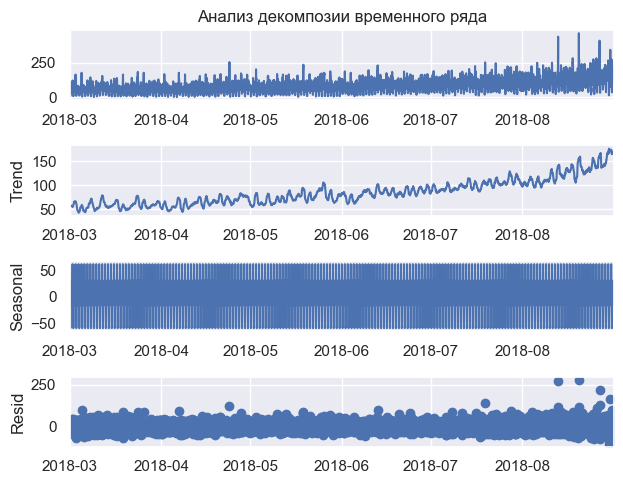

In [544]:
fig = seasonal_decompsition.plot()
fig.axes[0].set_title("Анализ декомпозии временного ряда");

**Выводы**
___
💠 Декомпозиция показывает общий восходящий тренд  
💠 В общем тренде все ещё прослеживается циклическая составляющая  
💠 В периодическую составлющую похоже отнесены изменения в течение дня
___

👀 Сделаем срез за 2 дня, чтобы изучить периодичность

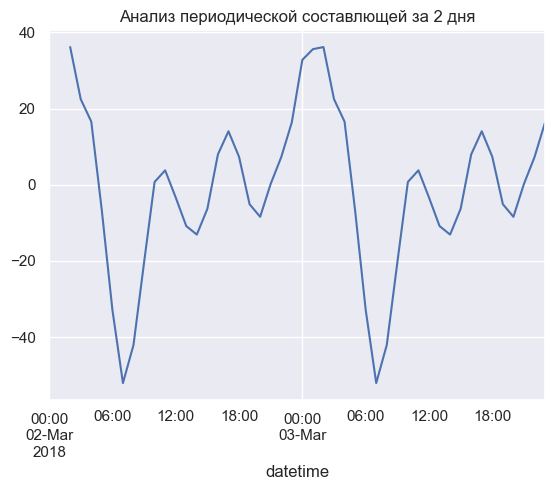

In [545]:
fig = (seasonal_decompsition.seasonal['2018-03-02': '2018-03-03']
       .rolling(3, win_type='gaussian')
       .mean(std=3).plot())
fig.axes.set_title("Анализ периодической составлющей за 2 дня");

**Выводы**
___
💠 Периодические
 - минимум: 6ч
 - максимум: 24(0)ч  
 
💠 Имеются по два локальных максимума и минимума
___

👀 Продолжим декомпозицию тренда

In [546]:
trend = seasonal_decompsition.trend.dropna()

In [547]:
trend_decompsition = seasonal_decompose(trend, period=168)

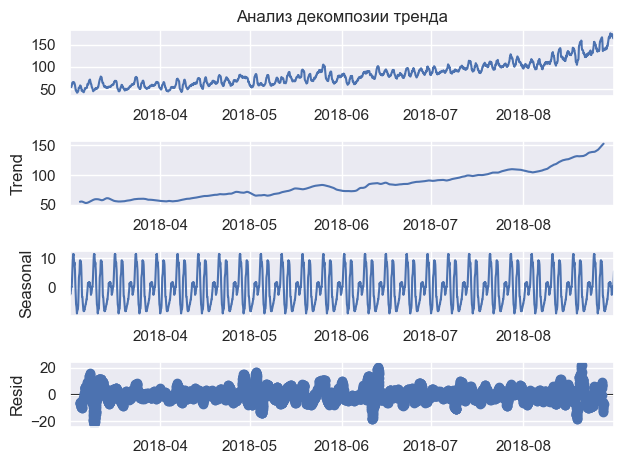

In [548]:
fig = trend_decompsition.plot()
fig.axes[0].set_title("Анализ декомпозии тренда");

**Выводы**
___
💠 Декомпозиция "очистила" общий восходящий тренд от циклической составляющей

💠 В периодическую составлющую похоже отнесены изменения в течение недели
___

👀 Сделаем срез за 2 недели, чтобы изучить периодичность

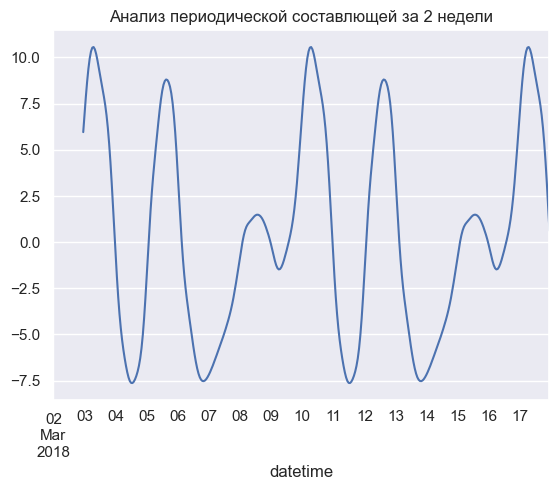

In [549]:
fig = (trend_decompsition.seasonal['2018-03-02': '2018-03-17']
       .rolling(24, win_type='gaussian')
       .mean(std=3).plot())
fig.axes.set_title("Анализ периодической составлющей за 2 недели");

**Выводы**
___
💠 Периодические
 - минимум: понедельник
 - максимум: выходные  
 
💠 С понедельника до восресенья идет рост с локальными максимумом (среда) и минимумом (четверг)
___

**Общие выводы по анализу данных**
___
💠Данные характеризются линейно восходящим `трендом` на 100 заказов за период
 - для указания точки на временной прямой достаточно использовать `день года`)
 
💠 Наиболее выражена `периодичность` в заказах в течение `суток`
 - время суток указывает признак `час`
 
💠 Дополнительно имеется `периодичность` в заказах в течение `недели`
 - на `день недели` указывает соответствующий признак
 
💠 Хорошее `сглаживание` данных обеспечивается данные сдвига за `3 часа` и за `3 дня`.

___

## Обучение

### Подготовка к обучению

Добавим признаки, необходимые для обучения

In [550]:
features = ['hour', 'dayofyear', 'weekday']
for feature in features:
    exec(f'data["{feature}"] = data.index.{feature}')

Добавим сдвиги за три предыдущих часа и три предыдущих дня

In [551]:
for shift in [1, 2, 3, 24, 48, 72]:
    data[f'shift_{shift}'] = data['num_orders'].shift(shift)

Удалим отсутствующие значения 

In [552]:
data.dropna(inplace=True)

Разобъём признаки и целевое значение на обучющие и тестовые выборки

In [553]:
Xtrain, Xtest, ytrain, ytest = train_test_split(
    data.drop('num_orders', axis=1),
    data['num_orders'],
    shuffle=False, test_size=.1
)

In [554]:
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

Создадим экземпляр сплиттера временных рядов для кросс-валидации

In [555]:
tscv = TimeSeriesSplit()

### Гребневая регрессия

Настройка параметров в конвейере:
- нормирование данных,
- аргументы для подбора,
- сплиттер временных рядов.

In [556]:
ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge_cv', RidgeCV(alphas=(1., 10., 50., 100.), cv=tscv))
])

Обучение

In [557]:
ridge_pipe.fit(Xtrain, ytrain)

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge_cv',
                 RidgeCV(alphas=(1.0, 10.0, 50.0, 100.0),
                         cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)))])

In [558]:
ridge_pipe.named_steps.ridge_cv.best_score_

0.5198504740842151

### Случайный лес

Параметры для подбора и настройка подбора параметров

In [559]:
params = {
    'n_estimators': list(range(50, 101, 10)),
    'max_depth': list(range(5, 16, 5))
}

In [560]:
rf_rs = RandomizedSearchCV(
    RandomForestRegressor(random_state=12345),
    param_distributions=params,
    cv=tscv
)

Обучение

In [561]:
rf_rs.fit(Xtrain, ytrain)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestRegressor(random_state=12345),
                   param_distributions={'max_depth': [5, 10, 15],
                                        'n_estimators': [50, 60, 70, 80, 90,
                                                         100]})

In [562]:
rf_rs.best_score_

0.5295222213216466

In [563]:
rf_rs.best_params_

{'n_estimators': 100, 'max_depth': 15}

**Общие выводы по обучению моделей**
___
💠Для обучения выбраны модели использованы
 - линейная модель с L2-регулязацией (Гребневая регрессия)
 - нелинейная модель Случайного леса
 
💠Для оценки результатов обучения кросс-валидацией использована
 - сплиттер для временных рядов (обеспечивает, что тест расположен позже по времени)
 
💠 Для линейной модели применено нормирование данных
 
💠 Лучший результат показала модель Гребневой регрессии

___

## Тестирование

In [564]:
mean_squared_error(ytest,
                   ridge_pipe.predict(Xtest),
                   squared=False)

42.240057851805155

**Общие выводы тестированию**
___
💠Значение метрики RMSE на линейная модель с L2-регулязацией (Гребневая регрессия) составила 42.2
 
💠Целевое значение метрики 48 не превышено. Успех!

___